In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
data = pd.read_csv('../data/cluster_Data.csv')

In [4]:
data.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
3,36.7,19.3,193.0,3450.0
4,39.3,20.6,190.0,3650.0


In [5]:
data.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


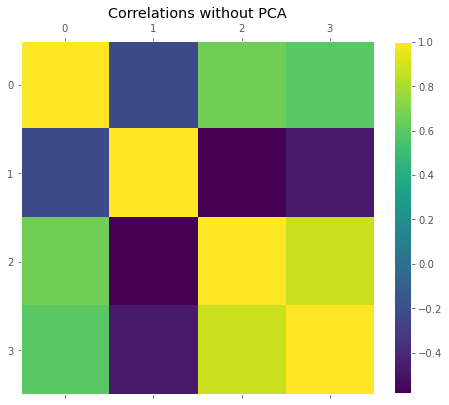

In [3]:
matfig = plt.figure(figsize=(7,7))
plt.matshow(data.corr(), fignum=matfig.number)
plt.grid(False)
plt.title('Correlations without PCA')
plt.colorbar(fraction = 0.045)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bill_length_mm     342 non-null    float64
 1   bill_depth_mm      342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
dtypes: float64(4)
memory usage: 10.8 KB


In [17]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture


def get_n_clusters(model, data):
    
    # elbow
    model_elbow = model
    visualizer = KElbowVisualizer(model_elbow, k=(2,30), show = False)
    visualizer.fit(data)
    n_clusters_elbow = visualizer.elbow_value_
    
    # silhouette
    model_silhouette = model
    visualizer = KElbowVisualizer(model_silhouette, k=(2,30), metric = 'silhouette', show = False)
    visualizer.fit(data)
    n_clusters_silhouette = visualizer.elbow_value_
    
    # calinski_harabasz
    
    model_calinski = model
    visualizer = KElbowVisualizer(model_calinski, k=(2,30),metric='calinski_harabasz', show = False)
    visualizer.fit(data)
    n_clusters_calinski = visualizer.elbow_value_
    
    plt.close()    
    n_components = range(1, 30)
    
    covariance_type = ['spherical', 'tied', 'diag', 'full']
    scores=[]
    
    for cov in covariance_type:
        for n_comp in n_components:
            gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 0)
            gmm.fit(data)
            scores.append((cov,n_comp,gmm.bic(data)))
    
    best_bic = min(scores, key = lambda r: r[2])
    print(best_bic)
    
    res =  {'elbow': n_clusters_elbow,
           'silhouette': n_clusters_silhouette, 
           'calinski_harabasz': n_clusters_calinski,
           'bic': best_bic[1]}
    
    votes = [res[list(res.keys())[i]] for i in range(len(res))] + [best_bic[1]]
    majority = max(set(votes), key = votes.count)
    
    return res, majority


In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans()
res, n_clusters = get_n_clusters(kmeans, data)

print('Result: ', res)
print('Majority: ', n_clusters)

('full', 3, 10558.287283867816)
Result:  {'elbow': 7, 'silhouette': 2, 'calinski_harabasz': 2, 'bic': 3}
Majority:  2


# 2D Visualization

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(data)

scaled_data = scaler.fit_transform(data)

# Umap

In [204]:
# TODO

# t-SNE

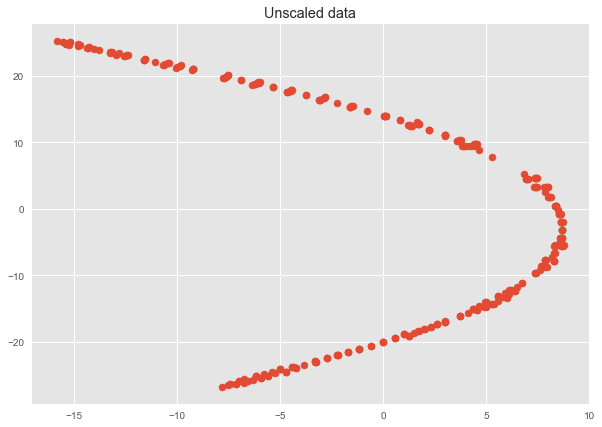

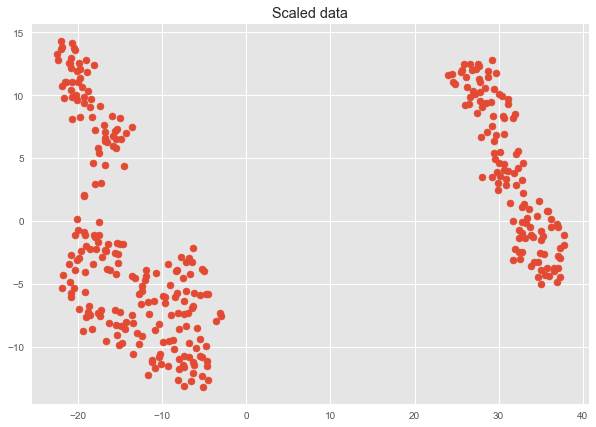

In [294]:
from sklearn.manifold import TSNE

tsne_components = TSNE(n_components=2, random_state = 0, perplexity = 30).fit_transform(data)

plt.figure(figsize = (10,7))
plt.scatter(tsne_components[:,0], tsne_components[:,1])
plt.title('Unscaled data')
plt.show()

tsne_components = TSNE(n_components=2, random_state = 0, perplexity = 30).fit_transform(scaled_data)

plt.figure(figsize = (10,7))
plt.scatter(tsne_components[:,0], tsne_components[:,1])
plt.title('Scaled data')
plt.show()

Som vi ser så ger TSNE en bättre separering när den kör på den skalade datan. 

# PCA

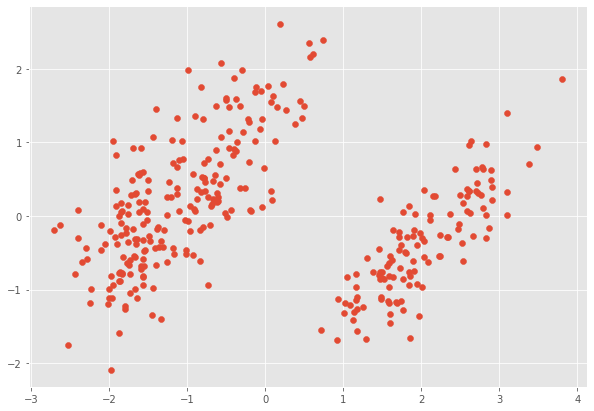

In [15]:
from sklearn.decomposition import PCA

# PCA kräver att alla features har samma skala så vi kör standardscaling på vår data så alla har ett 
# medelvärde på 0 och en standardavvikelse på 1. Annars hade pca sagt att kolumner med höga värden 
# bidrar med hög varians i datat, vilket nödvändigtvis inte är fallet.


pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

plt.figure(figsize = (10,7))
plt.scatter(principal_components[:,0], principal_components[:,1])
plt.show()

# GaussianMixture model

In [259]:
cv_types = ['full', 'tied', 'diag', 'spherical']
n_clusters = [2,3,4,5,6,7,8,9,10]

In [295]:
results = []

for n_c in n_clusters:
    for cv_t in cv_types:
        gm = GaussianMixture(n_components=n_c, random_state=0, covariance_type = cv_t).fit(data)
        res = {'model': gm, 'n_clusters': n_c, 'cv_type': cv_t, 'bic_score': gm.bic(data)}
        results.append(res)

In [296]:
best_gm = min(results, key = lambda res: res['bic_score'])

print(f"Covariance type: {best_gm['cv_type']}\nNumber of clusters: {best_gm['n_clusters']}\nBIC score: {round(best_gm['bic_score'], 1)}")
                                                                                                                                                                                              
                                                                                                  

Covariance type: full
Number of clusters: 3
BIC score: 10558.3


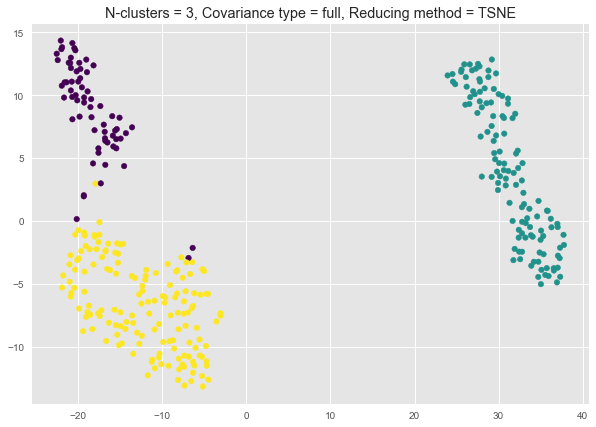

In [297]:
gm = GaussianMixture(n_components=3, random_state=0, covariance_type = 'full').fit(scaled_data)

plt.figure(figsize = (10,7))
plt.title('N-clusters = 3, Covariance type = full, Reducing method = TSNE')
plt.scatter(tsne_components[:,0], tsne_components[:,1], c = gm.predict(scaled_data), s = 30, cmap = 'viridis')
plt.show()

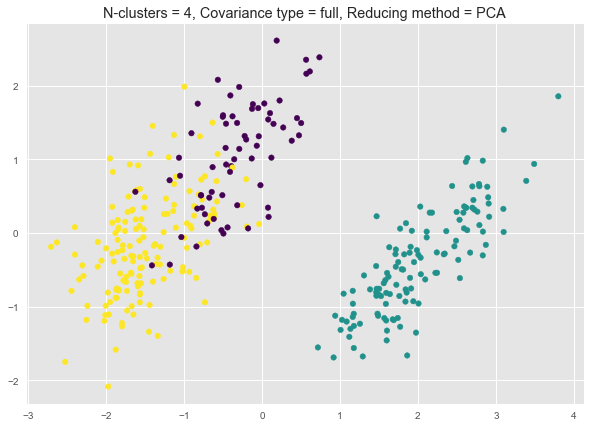

In [263]:
gm = GaussianMixture(n_components=3, random_state=0, covariance_type = 'full').fit(data)

plt.figure(figsize = (10,7))
plt.title('N-clusters = 4, Covariance type = full, Reducing method = PCA')
plt.scatter(principal_components[:,0], principal_components[:,1], c = gm.predict(data), s = 30, cmap = 'viridis')
plt.show()

Som vi ser så får vi bättre separering av datan med TSNE än med PCA. Därför kommer den framöver användas som visualiseringsverktyg

# DBSCAN

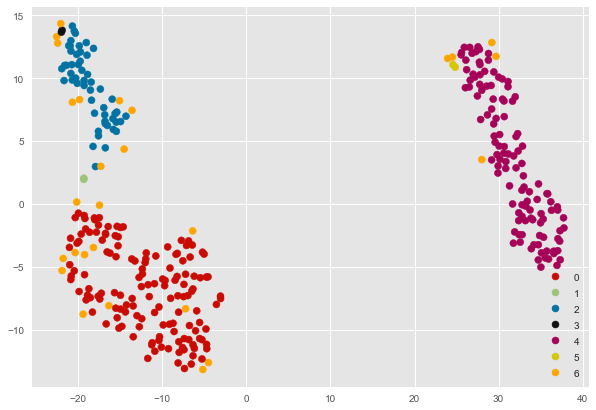

In [302]:
from matplotlib.colors import ListedColormap
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.55, min_samples=2).fit(scaled_data)

labels = clustering.labels_
labels = [label if label != -1 else 6 for label in labels]
colours = ListedColormap(['r', 'g', 'b', 'k', 'm', 'y', 'orange'])

plt.figure(figsize = (10,7))
scatter = plt.scatter(tsne_components[:,0], tsne_components[:,1], c=labels, cmap=colours)
plt.legend(*scatter.legend_elements(), loc = 4)
plt.show()

Som vi ser så har vi tre distinkta kluster, samt lite brus. Klasserna 0(röd), 2(blå) och 4(lila) är våra tre kluster

In [299]:
sorted_by_count = sorted([(value, labels.count(value)) for value in list(set(labels))], key = lambda v: -v[1])

main_clusters = sorted_by_count[:3]
print(main_clusters)

[(0, 141), (4, 116), (2, 52)]


In [300]:
n_noise_points = sum([c[1] for c in sorted_by_count[3:]])
print(f'Antal punkter som är brus: {n_noise_points}')

Antal punkter som är brus: 33


In [286]:
n_datapoints = len(data)
print(f'Totala antal punkter: {n_datapoints}')

Totala antal punkter: 342


In [287]:
noise_percentage = n_noise_points/n_datapoints
print(f"Brus utgör {round(noise_percentage*100, 1)} ‰ av datan")

Brus utgör 9.6 ‰ av datan


In [288]:
valid_data_labels = [0,2,4]
new_labels = []

# Vi annoterar alla punkter som är klassificerade som brus med 3
for label in labels:
    if label not in valid_data_labels:
        new_label = 3
        new_labels.append(new_label)
    else:
        # indexerar om
        new_labels.append(valid_data_labels.index(label))

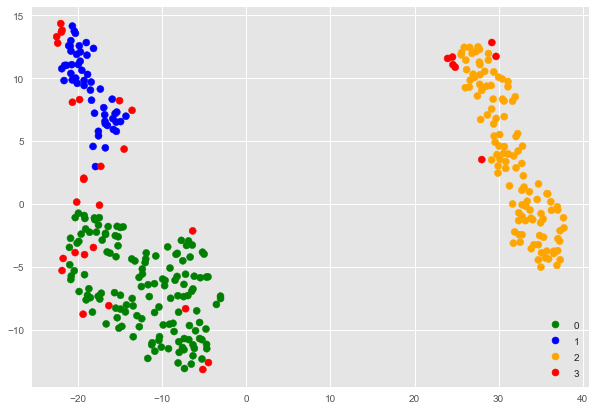

In [292]:
colours = ListedColormap(['green','blue','orange', 'red'])

plt.figure(figsize=(10,7))
scatter = plt.scatter(tsne_components[:,0], tsne_components[:,1], c=new_labels, cmap=colours)
plt.legend(*scatter.legend_elements(), loc = 4)
plt.show()